In [1]:
%matplotlib inline
import pandas

import nicenames


dup Desulfovibrio vulgaris DP4
dup Shewanella baltica OS223


In [13]:
def load_aligncov(filename):
    for line in open(filename):
        genome, cov, total, f_cov = line.strip().split()
        cov = int(float(cov))
        total = int(float(total))
        f_cov = float(f_cov)
        if f_cov == 0.0:
            #print('skipping', genome, nicenames.nicenames[genome])
            continue
        yield genome, cov, total, f_cov
        
iqc = list(load_aligncov('all-iqc-aligncov.txt'))
mqc = list(load_aligncov('all-mqc-aligncov.txt'))
sqc = list(load_aligncov('all-sqc-aligncov.txt'))

def cleanup(df):
    df['nicename'] = df['genome']
    df = df.replace({'nicename': nicenames.nicenames })
    df = df.drop('cov', axis=1)
    df = df.drop('total', axis=1)
    
    return df

idf = pandas.DataFrame(iqc, columns=['genome', 'cov', 'total', 'idba_cov'])
mdf = pandas.DataFrame(mqc, columns=['genome', 'cov', 'total', 'megahit_cov'])
sdf = pandas.DataFrame(sqc, columns=['genome', 'cov', 'total', 'spades_cov'])

idf = cleanup(idf)
mdf = cleanup(mdf)
sdf = cleanup(sdf)

combined = pandas.concat([idf, sdf, mdf], join='inner', axis=1)
combined.columns = ['genome', 'idba_cov', 'nicename', 'drop', 'spades_cov', 'drop', 'drop', 'megahit_cov', 'drop']

combined = combined.drop('drop', axis=1)
combined = combined.ix[:, ['nicename', 'idba_cov', 'spades_cov', 'megahit_cov', 'genome']]

cov_df = combined
cov_df[:5]

,nicename,idba_cov,spades_cov,megahit_cov,genome
0,Acidobacterium capsulatum ATCC 51196,0.994556,0.994782,0.995594,genomes/0.fa
1,Chlorobium limicola,0.967738,0.969488,0.973936,genomes/10.fa
2,Chlorobium phaeobacteroides,0.941313,0.949237,0.951151,genomes/11.fa
3,Chlorobiumphaeo vibrioides DSM 265,0.991616,0.992015,0.993620,genomes/12.fa
4,Chlorobium tepidum,0.993674,0.992868,0.997156,genomes/13.fa


In [5]:
bad_assembly = combined[(combined.megahit_cov < .95) | (combined.idba_cov < .95) | (combined.spades_cov < 0.95)]

In [15]:
print(len(bad_assembly))
bad_assembly

13


,nicename,idba_cov,spades_cov,megahit_cov,genome
2,Chlorobium phaeobacteroides,0.941313,0.949237,0.951151,genomes/11.fa
17,Methanococcus maripaludis S2,0.949618,0.977830,0.955904,genomes/30.fa
32,Salinispora arenicola,0.893290,0.933058,0.958994,genomes/45.fa
33,Shewanella baltica OS185,0.760255,0.757933,0.714042,genomes/47.fa
34,Sulfurihydrogenibium sp. YO3AOP1,0.939542,0.956704,0.897180,genomes/48.fa
35,Sulfurihydrogenibium yellowstonense SS-5,0.463601,0.195417,0.732355,genomes/49.fa
38,Thermotoga neapolitana,0.934985,0.878881,0.957401,genomes/51.fa
39,Thermotoga petrophila,0.456242,0.144996,0.729843,genomes/52.fa
40,Thermotoga sp. RQ2,0.907350,0.968984,0.903123,genomes/53.fa
44,Sulfitobacter sp. EE-36,0.688543,0.805980,0.670576,genomes/59.fa


In [9]:
import matplotlib.pyplot as pyplot

pyplot.style.use('seaborn-darkgrid') # I like 'fivethirtyeight'

def plot_coverage(x, figsize=(8,5)):
    fig = pyplot.figure(figsize=figsize)
    subp = fig.add_subplot(111)

    x = x.sort_values(by='megahit_cov', ascending=False)

    subp.plot(x.megahit_cov * 100., range(len(x)), 'o', label='MEGAHIT')
    subp.plot(x.idba_cov * 100., range(len(x)), 'd', label='IDBA')
    subp.plot(x.spades_cov * 100., range(len(x)), '>', label='SPAdes')

    pyplot.setp(subp, yticks=range(len(x)))
    
    strain_labels = []
    for name in x.nicename:
        if nicenames.is_strain(name):
            strain_labels.append(name + '$^*$')
        else:
            strain_labels.append(name)
        
    ytickNames = pyplot.setp(subp, yticklabels=strain_labels)
    pyplot.setp(ytickNames, fontsize=10)

    pyplot.axis(ymin=-1, xmin=0, xmax=100, ymax=len(x))
    pyplot.xlabel('Genome fraction covered (%)')
    pyplot.legend(loc='lower left')
    pyplot.subplots_adjust(left=0.5)



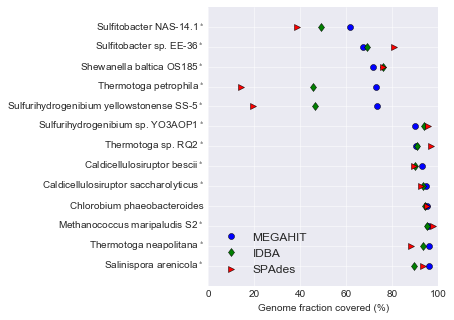

In [10]:
#print("\n".join(bad_assembly.genome))
plot_coverage(bad_assembly)
pyplot.savefig('aligncov.pdf')

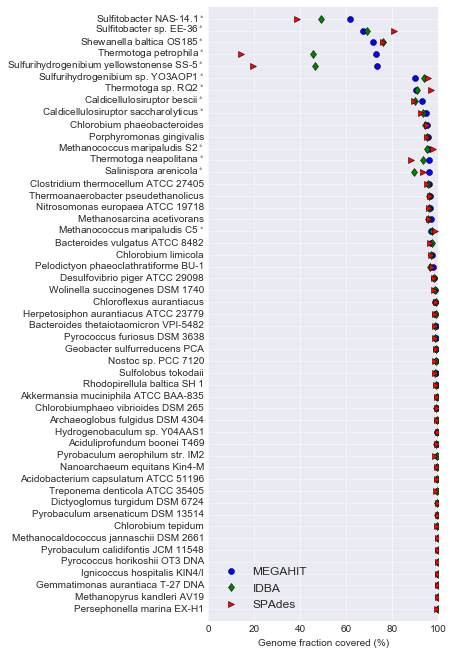

In [11]:
plot_coverage(combined, figsize=(8,11))
